In [1]:
from griddify import datasets

data = datasets.get_compound_descriptors()

In [2]:
from griddify import Preprocessing

pp  = Preprocessing()
pp.fit(data)
data = pp.transform(data)

In [8]:
from griddify import FeatureDistances

fd = FeatureDistances(metric="cosine").calculate(data)

In [17]:
from griddify import Tabular2Cloud


tc = Tabular2Cloud()
tc.fit(fd)
Xc = tc.transform(fd)


Running UMAP with precomputed distances


/home/mduranfrigola/miniconda3/envs/tab2grid/lib/python3.7/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


In [126]:
%matplotlib inline
import matplotlib.pyplot as plt

In [145]:
Xc[np.where(np.isnan(Xc))]

array([nan, nan, nan, nan, nan, nan, nan, nan], dtype=float32)

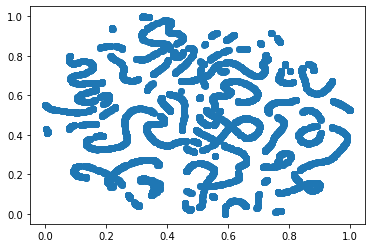

In [146]:
plt.scatter(Xc[:,0], Xc[:,1])

In [147]:
from griddify import Cloud2Grid

cg = Cloud2Grid(max_side=128)
cg.fit(Xc)
Xg = cg.transform(Xc, as_integers=False)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [129]:
from scipy.spatial.distance import euclidean
import matplotlib as mpl
from matplotlib import cm


def arrows_plot(X_cloud, X_grid, ax, capping_distance=0.5):
    cmap = cm.get_cmap("viridis")
    dists = []
    for start, end in zip(X_cloud, X_grid):
        dists += [euclidean(start, end)]
    norm = mpl.colors.Normalize(vmin=0, vmax=capping_distance)
    values = [norm(x) for x in dists]
    colors = [cmap(x) for x in values]
    i = 0
    for start, end in zip(X_cloud, X_grid):
        color = colors[i]
        ax.arrow(start[0], start[1], end[0] - start[0], end[1] - start[1], head_length=0.01, head_width=0.01, color=color)
        i += 1
    return ax

<AxesSubplot:>

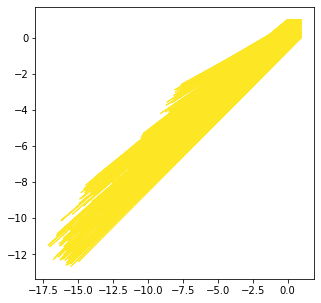

In [130]:
fig, ax = plt.subplots(1,1, figsize=(5,5))

arrows_plot(Xc, Xg, ax=ax, capping_distance=0.5)

In [122]:
Xg = cg.transform(Xc, as_integers=True)

import numpy as np


class Tabular2Grid(object):

    def __init__(self, cloud2grid):
        self._size = cloud2grid._side
        self._empty_grid = cloud2grid.get_empty_grid()
        
    def fit(self, X_grid):
        assert X_grid.astype(int) == X_grid
        self._mapper = X_grid
        
    def transform(self, X):
        Xt = []
        for i in X.shape[0]:
            g = self._empty_grid.copy()
            x = X[i,:]
            for j, v in enumerate(x):
                idx_i, idx_j = self._mapper[j]
                g[idx_i, idx_j] = v
            Xt += [g]
        return np.array(Xt)

tg = Tabular2Grid(cg)
tg.fit(Xg)

AttributeError: 'Cloud2Grid' object has no attribute 'get_empty_grid'

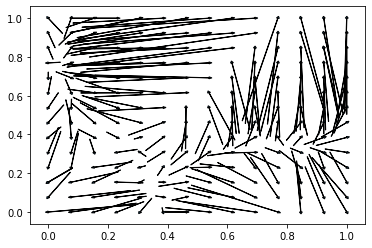

In [70]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(Xc)
Xc = scaler.transform(Xc)

for start, end in zip(Xc, Xg):
    plt.arrow(start[0], start[1], end[0] - start[0], end[1] - start[1],
              head_length=0.01, head_width=0.01)
plt.show()

array([[0.69230769, 0.        ],
       [1.        , 0.84615385],
       [1.        , 0.15384615],
       [0.92307692, 0.23076923],
       [0.92307692, 0.30769231],
       [0.84615385, 0.07692308],
       [0.76923077, 0.53846154],
       [0.76923077, 0.23076923],
       [0.76923077, 0.07692308],
       [0.76923077, 0.30769231],
       [0.69230769, 0.23076923],
       [0.69230769, 0.53846154],
       [0.69230769, 0.61538462],
       [0.69230769, 0.69230769],
       [0.84615385, 0.84615385],
       [0.84615385, 0.69230769],
       [0.30769231, 0.76923077],
       [0.84615385, 0.61538462],
       [0.92307692, 0.07692308],
       [0.92307692, 0.61538462],
       [0.84615385, 0.        ],
       [0.92307692, 0.        ],
       [1.        , 0.23076923],
       [1.        , 0.        ],
       [0.76923077, 1.        ],
       [1.        , 0.76923077],
       [0.53846154, 0.30769231],
       [0.53846154, 0.38461538],
       [0.61538462, 0.23076923],
       [0.38461538, 0.30769231],
       [0.